In [130]:
import pandas as pd
import numpy as np
import laspy
import matplotlib.pyplot as plt
import os
import math
import heapq
import random


In [131]:
# Load the .laz file from the data directory
file_path = os.path.join("data", "point_cloud.laz")
las = laspy.read(file_path)

# Extract x, y, z points into an array
points = np.vstack((las.x, las.y, las.z)).transpose()
print("Loaded points shape:", points.shape)


Loaded points shape: (11162018, 3)


In [132]:
# Define the ground level range using percentiles to capture the ground more precisely
ground_lower_percentile = 5   # Lower bound for ground level (percentile)
ground_upper_percentile = 15  # Upper bound for ground level (percentile)

# Calculate the z-value range for ground level
z_lower = np.percentile(points[:, 2], ground_lower_percentile)
z_upper = np.percentile(points[:, 2], ground_upper_percentile)

# Filter points that fall within the ground level range
ground_points = points[(points[:, 2] >= z_lower) & (points[:, 2] <= z_upper)]

print("Filtered ground points shape:", ground_points.shape)
print(f"Ground level range: {z_lower} to {z_upper}")


Filtered ground points shape: (1189, 3)


In [133]:
# Define grid parameters
grid_size = 100  # Adjust for desired resolution
occupancy_grid = np.zeros((grid_size, grid_size))

# Calculate bounds based on ground points' x and y coordinates
min_x, max_x = ground_points[:, 0].min(), ground_points[:, 0].max()
min_y, max_y = ground_points[:, 1].min(), ground_points[:, 1].max()

# Populate the occupancy grid: 1 indicates an obstacle, 0 indicates free space
for point in ground_points:
    x_idx = int((point[0] - min_x) / (max_x - min_x) * (grid_size - 1))
    y_idx = int((point[1] - min_y) / (max_y - min_y) * (grid_size - 1))
    occupancy_grid[x_idx, y_idx] = 1  # Mark as obstacle

print("Occupancy grid created.")


Occupancy grid created.


In [134]:
# Check the proportion of free vs obstacle cells
obstacle_count = np.sum(occupancy_grid == 1)
free_count = np.sum(occupancy_grid == 0)
total_cells = occupancy_grid.size

print(f"Total cells: {total_cells}")
print(f"Free cells: {free_count} ({(free_count / total_cells) * 100:.2f}%)")
print(f"Obstacle cells: {obstacle_count} ({(obstacle_count / total_cells) * 100:.2f}%)")


Total cells: 250000
Free cells: 248811 (99.52%)
Obstacle cells: 1189 (0.48%)


In [135]:
# A* Heuristic function (Euclidean distance)
def heuristic(node, goal):
    return np.sqrt((node[0] - goal[0]) ** 2 + (node[1] - goal[1]) ** 2)

# Get neighboring cells for A*
def get_neighbors(node, grid):
    neighbors = []
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Down, Left, Right
    for d in directions:
        neighbor = (node[0] + d[0], node[1] + d[1])
        if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
            if grid[neighbor[0], neighbor[1]] == 0:  # Check if traversable
                neighbors.append(neighbor)
    return neighbors

# A* Pathfinding function
def a_star(start, goal, grid):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    
    g_cost = {start: 0}
    f_cost = {start: heuristic(start, goal)}
    
    while open_set:
        current = heapq.heappop(open_set)[1]
        
        if current == goal:
            return reconstruct_path(came_from, current)
        
        for neighbor in get_neighbors(current, grid):
            tentative_g_cost = g_cost[current] + 1  # Uniform cost for simplicity
            
            if neighbor not in g_cost or tentative_g_cost < g_cost[neighbor]:
                came_from[neighbor] = current
                g_cost[neighbor] = tentative_g_cost
                f_cost[neighbor] = g_cost[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_cost[neighbor], neighbor))
    
    return None  # Return None if no path is found

# Path reconstruction function
def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path


In [136]:
# Manually select start and goal in free (white) areas based on visualization
start, goal = (10, 10), (90, 90)  # Adjust these based on actual free spots found in the grid

print("Start Position:", start)
print("Goal Position:", goal)


Start Position: (10, 10)
Goal Position: (90, 90)


Path found: [(10, 10), (10, 11), (11, 11), (11, 12), (12, 12), (12, 13), (13, 13), (13, 14), (14, 14), (14, 15), (15, 15), (15, 16), (16, 16), (16, 17), (17, 17), (17, 18), (18, 18), (18, 19), (19, 19), (19, 20), (20, 20), (20, 21), (21, 21), (21, 22), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (24, 25), (25, 25), (25, 26), (26, 26), (26, 27), (27, 27), (27, 28), (28, 28), (28, 29), (29, 29), (29, 30), (30, 30), (30, 31), (31, 31), (31, 32), (32, 32), (32, 33), (33, 33), (33, 34), (34, 34), (34, 35), (35, 35), (35, 36), (36, 36), (36, 37), (37, 37), (38, 37), (38, 38), (38, 39), (39, 39), (39, 40), (40, 40), (40, 41), (41, 41), (41, 42), (42, 42), (43, 42), (43, 43), (43, 44), (44, 44), (44, 45), (45, 45), (45, 46), (46, 46), (46, 47), (47, 47), (47, 48), (48, 48), (48, 49), (49, 49), (49, 50), (50, 50), (50, 51), (51, 51), (51, 52), (52, 52), (52, 53), (53, 53), (53, 54), (54, 54), (54, 55), (55, 55), (55, 56), (56, 56), (56, 57), (57, 57), (57, 58), (58, 58), (58, 59), (59, 59

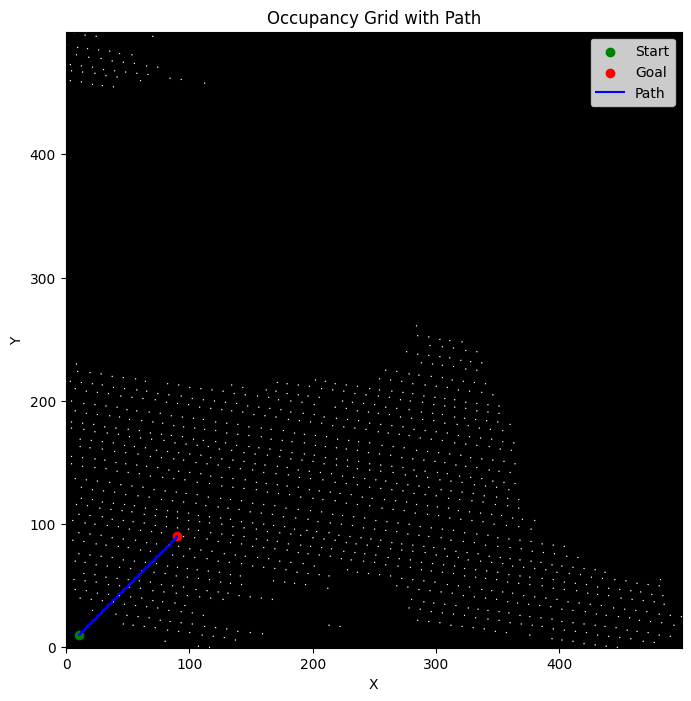

In [137]:
# Run the A* algorithm
path = a_star(start, goal, occupancy_grid)
if path is None:
    print("No path found.")
else:
    print("Path found:", path)

    # Convert path to plot on the original scale
    path_points = np.array([(pt[0] * (max_x - min_x) / (grid_size - 1) + min_x,
                             pt[1] * (max_y - min_y) / (grid_size - 1) + min_y,
                             0) for pt in path])

    # Plot the path and the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(occupancy_grid, cmap="gray", origin="lower")
    plt.scatter([start[1]], [start[0]], color="green", label="Start")
    plt.scatter([goal[1]], [goal[0]], color="red", label="Goal")
    plt.plot([pt[1] for pt in path], [pt[0] for pt in path], color="blue", label="Path")
    plt.legend()
    plt.title("Occupancy Grid with Path")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


In [138]:
# Initialize a 2D array to store elevation values for each cell
elevation_grid = np.full((grid_size, grid_size), np.nan)

# Populate the occupancy and elevation grids
for point in ground_points:
    x_idx = int((point[0] - min_x) / (max_x - min_x) * (grid_size - 1))
    y_idx = int((point[1] - min_y) / (max_y - min_y) * (grid_size - 1))
    occupancy_grid[x_idx, y_idx] = 1  # Mark as obstacle
    if np.isnan(elevation_grid[x_idx, y_idx]):
        elevation_grid[x_idx, y_idx] = point[2]  # Set initial elevation
    else:
        # Average the elevation in each cell if multiple points fall into it
        elevation_grid[x_idx, y_idx] = (elevation_grid[x_idx, y_idx] + point[2]) / 2


In [139]:
# Modified A* pathfinding function with elevation consideration
def a_star_with_elevation(start, goal, grid, elevation_grid):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}

    g_cost = {start: 0}
    f_cost = {start: heuristic(start, goal)}

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(current, grid):
            # Calculate elevation cost as the difference in elevation between current and neighbor
            current_elevation = elevation_grid[current[0], current[1]]
            neighbor_elevation = elevation_grid[neighbor[0], neighbor[1]]
            elevation_change_cost = abs(neighbor_elevation - current_elevation)

            # Total movement cost includes elevation change penalty
            tentative_g_cost = g_cost[current] + 1 + elevation_change_cost

            if neighbor not in g_cost or tentative_g_cost < g_cost[neighbor]:
                came_from[neighbor] = current
                g_cost[neighbor] = tentative_g_cost
                f_cost[neighbor] = g_cost[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_cost[neighbor], neighbor))

    return None  # Return None if no path is found


In [140]:
# Run the A* algorithm with elevation cost
path = a_star_with_elevation(start, goal, occupancy_grid, elevation_grid)

if path is None:
    print("No path found.")
else:
    print("Path found:", path)
    # Use the same 3D visualization from earlier to plot the path


Path found: [(10, 10), (10, 9), (10, 8), (9, 8), (8, 8), (8, 7), (7, 7), (6, 7), (5, 7), (4, 7), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (97, 0),

In [141]:
# Find corresponding 3D ground points for each 2D path point
path_points_3d = []
for (x_idx, y_idx) in path:
    # Map 2D grid point back to x, y in original scale
    x_coord = x_idx * (max_x - min_x) / (grid_size - 1) + min_x
    y_coord = y_idx * (max_y - min_y) / (grid_size - 1) + min_y
    
    # Find the closest 3D point in ground_points to this 2D location
    dists = np.sqrt((ground_points[:, 0] - x_coord) ** 2 + (ground_points[:, 1] - y_coord) ** 2)
    closest_point = ground_points[np.argmin(dists)]
    path_points_3d.append(closest_point)

path_points_3d = np.array(path_points_3d)


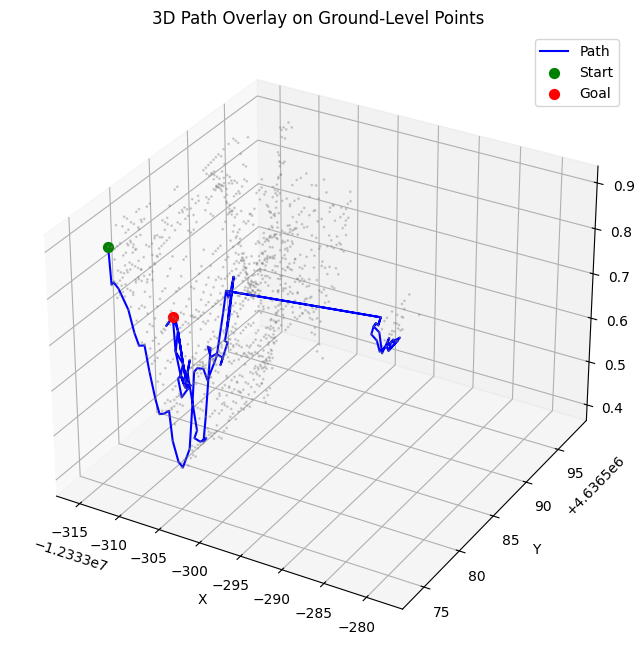

In [142]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all ground-level points in the 3D point cloud
ax.scatter(ground_points[:, 0], ground_points[:, 1], ground_points[:, 2], s=1, color='gray', alpha=0.3)

# Plot the 3D path
ax.plot(path_points_3d[:, 0], path_points_3d[:, 1], path_points_3d[:, 2], color='blue', label="Path")
ax.scatter(path_points_3d[0, 0], path_points_3d[0, 1], path_points_3d[0, 2], color='green', s=50, label="Start")
ax.scatter(path_points_3d[-1, 0], path_points_3d[-1, 1], path_points_3d[-1, 2], color='red', s=50, label="Goal")

# Label and show the plot
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.title("3D Path Overlay on Ground-Level Points")
plt.show()
